In [13]:
import torch
import torchvision

model1 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
print(model1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ===== GelSight Encoder =====
class GelSightEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Replace FC layer with Identity so we can add our own
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Identity()
        self.backbone = resnet
        self.fc = nn.Linear(num_ftrs, latent_dim)

    def forward(self, x):
        feats = self.backbone(x)      # (B, num_ftrs)
        feats = self.fc(feats)        # (B, latent_dim)
        return F.normalize(feats, dim=1)


# ===== Shadow Hand Encoder =====
class ShadowHandEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(2, 3), stride=1, padding=0),  # (B, 16, 2, 15)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),  # (B, 32, 1, 13)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 3 * 13, latent_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)       # (B, latent_dim)
        return F.normalize(feats, dim=1)


# ===== Combined Model =====
class CrossModalModel(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.gelsight_encoder = GelSightEncoder(latent_dim)
        self.shadowhand_encoder = ShadowHandEncoder(latent_dim)

    def forward(self, gelsight, shadowhand):
        z_gel = self.gelsight_encoder(gelsight)
        z_hand = self.shadowhand_encoder(shadowhand)
        return z_gel, z_hand


# ===== InfoNCE Loss =====
def info_nce_loss(z1, z2, temperature=0.07):
    """
    Compute InfoNCE loss between two sets of embeddings.
    z1, z2: shape (B, D) normalized embeddings
    """
    batch_size = z1.shape[0]

    # Cosine similarity matrix
    logits = torch.matmul(z1, z2.T) / temperature

    labels = torch.arange(batch_size, device=z1.device)
    # Cross-entropy over rows (z1 as query, z2 as key) and columns (symmetry)
    loss_i = F.cross_entropy(logits, labels)
    loss_j = F.cross_entropy(logits.T, labels)

    return (loss_i + loss_j) / 2


# ===== Example Training Step =====
if __name__ == "__main__":
    latent_dim = 512
    model = CrossModalModel(latent_dim=latent_dim)

    gelsight_batch = torch.randn(8, 3, 224, 224)   # 8 samples
    shadowhand_batch = torch.randn(8, 3, 5, 17)    # 8 samples

    z_gel, z_hand = model(gelsight_batch, shadowhand_batch)
    loss = info_nce_loss(z_gel, z_hand)

    print(f"z_gel shape: {z_gel.shape}, z_hand shape: {z_hand.shape}")
    print(f"Loss: {loss.item():.4f}")


z_gel shape: torch.Size([8, 512]), z_hand shape: torch.Size([8, 512])
Loss: 2.1578


In [26]:
from torchvision import datasets, models, transforms
import numpy as np
DATASET_DIR = "sh_gs_processed"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

gs_dataset = datasets.ImageFolder(DATASET_DIR, transform=transform)
print(gs_dataset)

arr, label = gs_dataset[0]
print(arr.shape)



Dataset ImageFolder
    Number of datapoints: 600
    Root location: sh_gs_processed
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
torch.Size([3, 224, 224])


In [25]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class NPYFolder(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (str): Root directory (e.g., 'sh_gs_tactile/')
            transform (callable, optional): Transform to apply to the input array
            target_transform (callable, optional): Transform to apply to the label
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []
        self.class_to_idx = {}

        # Discover classes
        classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Collect (path, label) pairs
        for cls_name, idx in self.class_to_idx.items():
            cls_folder = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.endswith(".npy"):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        arr = np.load(path)

        # Convert to torch tensor (C, H, W) instead of (H, W, C)
        # Your data is (5, 17, 3) → permute → (3, 5, 17)
        arr = torch.tensor(arr, dtype=torch.float32).permute(2, 0, 1)

        if self.transform:
            arr = self.transform(arr)
        if self.target_transform:
            label = self.target_transform(label)

        return arr, label

sh_dataset = NPYFolder("sh_gs_tactile")
print(sh_dataset.class_to_idx)
arr, label = sh_dataset[0]
print(arr.shape)

{'down': 0, 'left': 1, 'right': 2, 'up': 3}
torch.Size([3, 5, 17])


In [29]:
from torch.utils.data import random_split
from torch.utils.data import Subset

# ------------------ split both datasets with the same split ----------------- #
# Set split ratio and random seed for reproducibility
val_ratio = 0.2
total_len = len(gs_dataset)
val_len = int(total_len * val_ratio)
train_len = total_len - val_len

# Use the same generator for both splits
generator = torch.Generator().manual_seed(42)
train_indices, val_indices = torch.utils.data.random_split(
    range(total_len), [train_len, val_len], generator=generator
)

# Subset both datasets using the same indices

gs_train = Subset(gs_dataset, train_indices.indices)
gs_val = Subset(gs_dataset, val_indices.indices)
sh_train = Subset(sh_dataset, train_indices.indices)
sh_val = Subset(sh_dataset, val_indices.indices)

print(len(gs_train), len(gs_val), len(sh_train), len(sh_val))

480 120 480 120


In [38]:
from torch.utils.data import DataLoader

import torch.optim as optim

# Hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoaders for training and validation
gs_train_loader = DataLoader(gs_train, batch_size=batch_size)
sh_train_loader = DataLoader(sh_train, batch_size=batch_size)
gs_val_loader = DataLoader(gs_val, batch_size=batch_size)
sh_val_loader = DataLoader(sh_val, batch_size=batch_size)

latent_dim = 512
model = CrossModalModel(latent_dim=latent_dim)
# Model, optimizer
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch(model, gs_loader, sh_loader, optimizer, device):
    model.train()
    total_loss = 0
    for (gs_batch, _), (sh_batch, _) in zip(gs_loader, sh_loader):
        gs_batch = gs_batch.to(device)
        sh_batch = sh_batch.to(device)
        optimizer.zero_grad()
        z_gel, z_hand = model(gs_batch, sh_batch)
        loss = info_nce_loss(z_gel, z_hand)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * gs_batch.size(0)
    return total_loss / len(gs_loader.dataset)

def validate(model, gs_loader, sh_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (gs_batch, _), (sh_batch, _) in zip(gs_loader, sh_loader):
            gs_batch = gs_batch.to(device)
            sh_batch = sh_batch.to(device)
            z_gel, z_hand = model(gs_batch, sh_batch)
            loss = info_nce_loss(z_gel, z_hand)
            total_loss += loss.item() * gs_batch.size(0)
    return total_loss / len(gs_loader.dataset)

loss_list = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, gs_train_loader, sh_train_loader, optimizer, device)
    val_loss = validate(model, gs_val_loader, sh_val_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    loss_list.append((train_loss, val_loss))

Epoch 1/100 | Train Loss: 3.4516 | Val Loss: 3.3914
Epoch 2/100 | Train Loss: 3.0559 | Val Loss: 2.3816
Epoch 3/100 | Train Loss: 2.1986 | Val Loss: 1.8700
Epoch 4/100 | Train Loss: 1.7270 | Val Loss: 1.5002
Epoch 5/100 | Train Loss: 1.4274 | Val Loss: 1.5800
Epoch 6/100 | Train Loss: 1.2641 | Val Loss: 1.3235
Epoch 7/100 | Train Loss: 1.2099 | Val Loss: 1.2602
Epoch 8/100 | Train Loss: 1.1564 | Val Loss: 1.2660
Epoch 9/100 | Train Loss: 1.0993 | Val Loss: 1.0422
Epoch 10/100 | Train Loss: 1.0526 | Val Loss: 1.1681
Epoch 11/100 | Train Loss: 1.0454 | Val Loss: 0.9103
Epoch 12/100 | Train Loss: 0.8848 | Val Loss: 1.0009
Epoch 13/100 | Train Loss: 0.8545 | Val Loss: 0.8811
Epoch 14/100 | Train Loss: 0.8452 | Val Loss: 0.8427
Epoch 15/100 | Train Loss: 0.9677 | Val Loss: 1.1648
Epoch 16/100 | Train Loss: 1.0013 | Val Loss: 1.0855
Epoch 17/100 | Train Loss: 1.0098 | Val Loss: 0.8693
Epoch 18/100 | Train Loss: 0.8949 | Val Loss: 0.7949
Epoch 19/100 | Train Loss: 0.7632 | Val Loss: 0.7509
Ep

In [ ]:
# Save both models (GelSight encoder and ShadowHand encoder) separately
torch.save(model.gelsight_encoder.state_dict(), "gelsight_encoder.pth")
torch.save(model.shadowhand_encoder.state_dict(), "shadowhand_encoder.pth")

In [52]:
import torch.nn.functional as F
# Example usage of the model
# Take a batch from the training loaders
gs_batch, _ = next(iter(gs_train_loader))
sh_batch, _ = next(iter(sh_train_loader))

gs_batch = gs_batch.to(device)
sh_batch = sh_batch.to(device)

# Get embeddings
z1 = model.gelsight_encoder(gs_batch)
z2 = model.shadowhand_encoder(sh_batch)

# z_random: shuffle sh_batch to get a negative pair
sh_batch_random = sh_batch[torch.randperm(sh_batch.size(0))]
z_random = model.shadowhand_encoder(sh_batch_random)
sim = F.cosine_similarity(z1, z2)   # positive pair
sim_neg = F.cosine_similarity(z1, z_random)  # negative pair
print(sim.mean().item(), sim_neg.mean().item())

0.7616751194000244 -0.06306778639554977


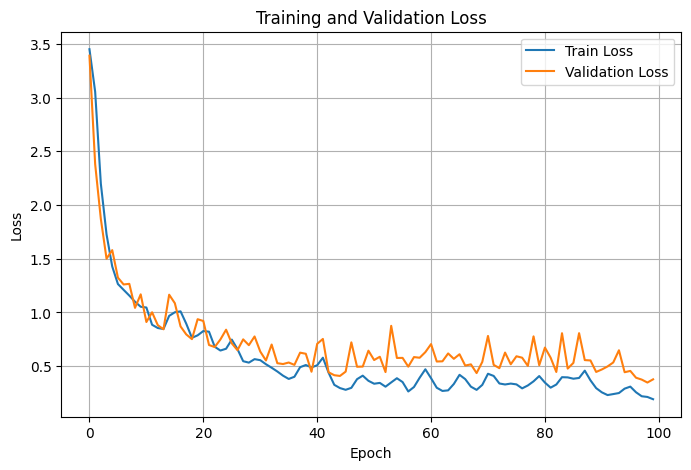

In [53]:
import matplotlib.pyplot as plt

# Unpack train and validation losses
train_losses, val_losses = zip(*loss_list)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()